In [1]:
import pandas as pd
import numpy as np
import math

RANDOM_STATE = 123
np.random.seed(123)

## Load data

In [6]:
df_gym_raw = pd.read_csv('data/gym_members_exercise_tracking.csv')

In [7]:
df_heart_rates = pd.read_csv('data/gym_members_heart_rates.csv')

In [20]:
df_heart_rates.head(20)

,User_ID,Heart_Rate
0,0,155
1,0,167
2,0,158
3,0,167
4,0,150
5,0,148
6,0,167
7,0,166
8,0,152
9,0,164


In [9]:
not_null_members = df_heart_rates['User_ID'].unique()

In [17]:
df_gym = df_gym_raw.loc[not_null_members]

In [ ]:
df_heart_rates[df_heart_rates['User_ID'] == 0]['Heart_Rate'].tolist()

101

## Energy calculation - Fuzzy Logic

In [25]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [26]:
bpm_antecedent = ctrl.Antecedent(np.arange(30, 201, 1), 'BPM')
bpm_variation_antecedent = ctrl.Antecedent(np.arange(-30, 31, 1), 'BPM Variation')
intensity_consequent = ctrl.Consequent(np.arange(0, 101, 1), 'Intensity')

In [27]:
bpm_antecedent.automf(5, names=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
bpm_variation_antecedent.automf(3, names=['Negative', 'Zero', 'Positive'])
intensity_consequent.automf(3, names=['Low', 'Medium', 'High'])

c:\Users\Dani\.conda\envs\Master-IA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


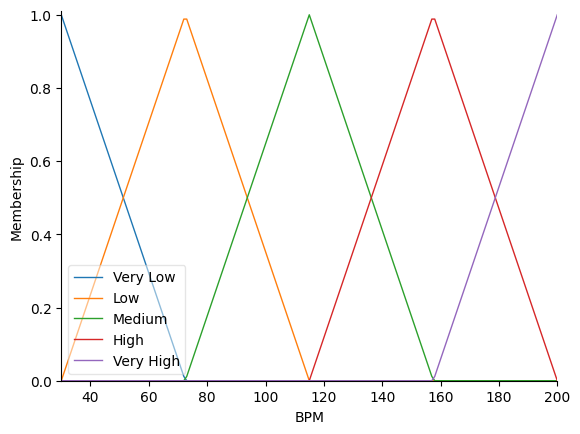

In [28]:
bpm_antecedent.view()

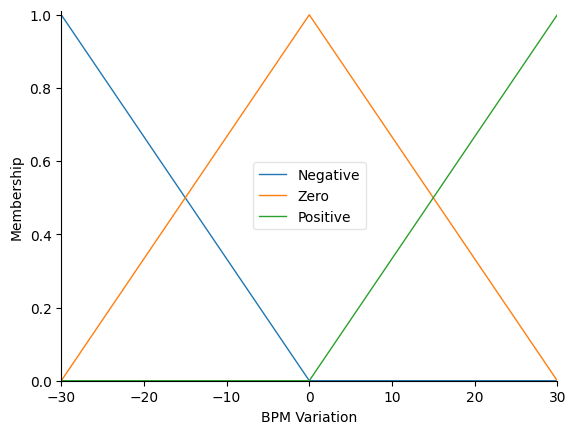

In [29]:
bpm_variation_antecedent.view()

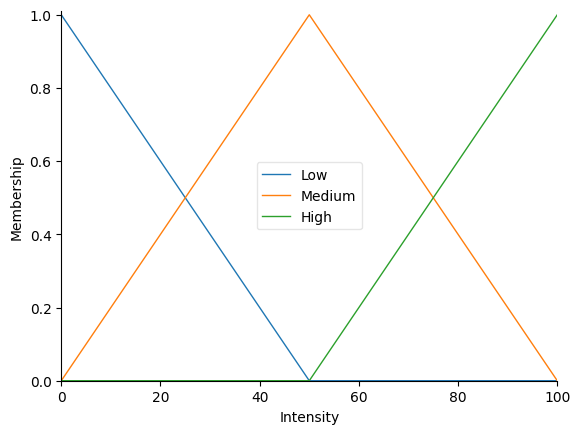

In [30]:
intensity_consequent.view()

In [31]:
# rule1 = ctrl.Rule(bpm_antecedent['Very Low'] , intensity_consequent['High'])
# rule2 = ctrl.Rule(bpm_antecedent['Low'], bpm_variation_antecedent['Negative'], intensity_consequent['High'])
# rule3 = ctrl.Rule(bpm_antecedent['Low'], bpm_variation_antecedent['Zero'], intensity_consequent['High'])
# rule4 = ctrl.Rule(bpm_antecedent['Low'], bpm_variation_antecedent['Positive'], intensity_consequent['Medium'])
# rule5 = ctrl.Rule(bpm_antecedent['Medium'], bpm_variation_antecedent['Negative'], intensity_consequent['High'])
# rule6 = ctrl.Rule(bpm_antecedent['Medium'], bpm_variation_antecedent['Zero'], intensity_consequent['Medium'])
# rule7 = ctrl.Rule(bpm_antecedent['Medium'], bpm_variation_antecedent['Positive'], intensity_consequent['Low'])
# rule8 = ctrl.Rule(bpm_antecedent['High'], bpm_variation_antecedent['Negative'], intensity_consequent['Medium'])
# rule9 = ctrl.Rule(bpm_antecedent['High'], bpm_variation_antecedent['Zero'], intensity_consequent['Low'])
# rule10 = ctrl.Rule(bpm_antecedent['High'], bpm_variation_antecedent['Positive'], intensity_consequent['Low'])
# rule11 = ctrl.Rule(bpm_antecedent['Very High'], intensity_consequent['Low'])

rule1 = ctrl.Rule(antecedent= (bpm_antecedent['Very Low'] |
                        (bpm_antecedent['Low'] & bpm_variation_antecedent['Negative']) |
                        (bpm_antecedent['Low'] & bpm_variation_antecedent['Zero']) |
                        (bpm_antecedent['Medium'] & bpm_variation_antecedent['Negative'])),
                        consequent=intensity_consequent['High'])
rule2 = ctrl.Rule(antecedent=((bpm_antecedent['Low'] & bpm_variation_antecedent['Positive']) |
                        (bpm_antecedent['Medium'] & bpm_variation_antecedent['Zero']) |
                        (bpm_antecedent['High'] & bpm_variation_antecedent['Negative'])),
                        consequent=intensity_consequent['Medium'])
rule3 = ctrl.Rule(antecedent=((bpm_antecedent['Medium'] & bpm_variation_antecedent['Positive']) |
                        (bpm_antecedent['High'] & bpm_variation_antecedent['Zero']) |
                        (bpm_antecedent['High'] & bpm_variation_antecedent['Positive'])),
                        consequent=intensity_consequent['Low'])

In [32]:
intensity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
intensity_sim = ctrl.ControlSystemSimulation(intensity_ctrl)

In [33]:
def calculate_intensity_fuzzy(bpm, bpm_variation, plot_consequent=False, plot_antecedent=False):
    intensity_sim.input['BPM'] = bpm
    intensity_sim.input['BPM Variation'] = bpm_variation
    intensity_sim.compute()
    if plot_consequent:
        intensity_consequent.view(sim=intensity_sim)
    if plot_antecedent:
        bpm_antecedent.view(sim=intensity_sim)
        bpm_variation_antecedent.view(sim=intensity_sim)
    return intensity_sim.output['Intensity']

#### Basic example

np.float64(47.384170156698524)

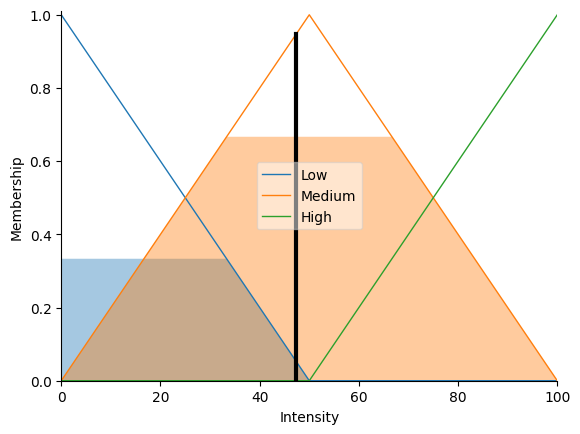

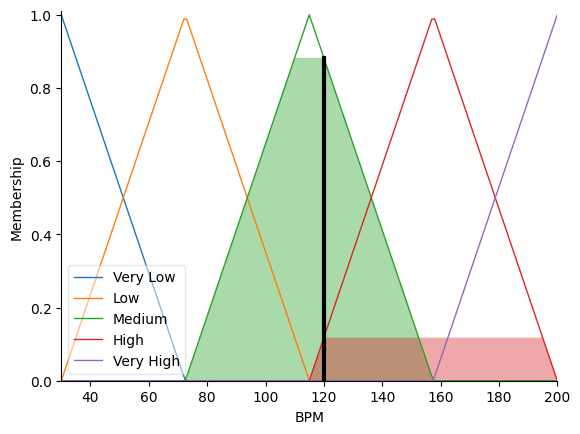

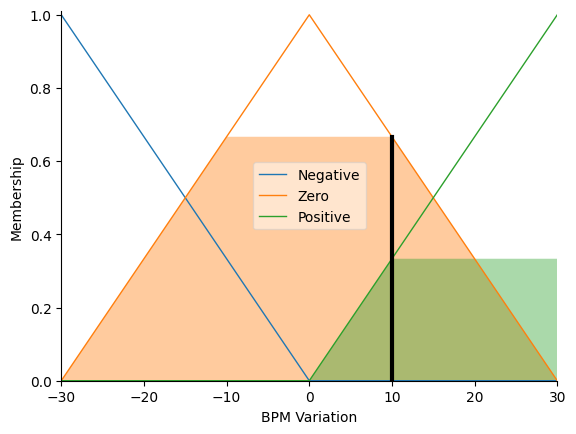

In [39]:
bpm = 120
bpm_variation = 10
calculate_intensity_fuzzy(bpm, bpm_variation, plot_consequent = True, plot_antecedent = True)

np.float64(75.45998530595496)

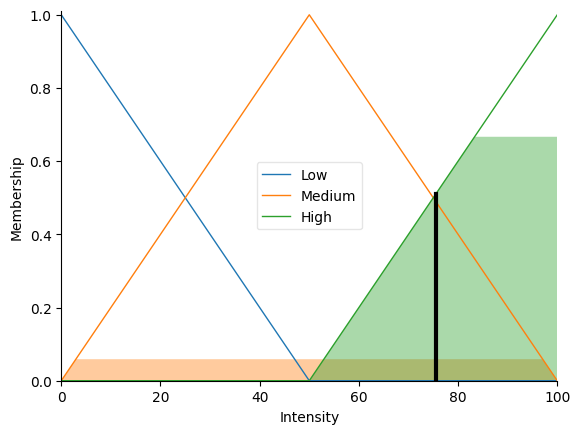

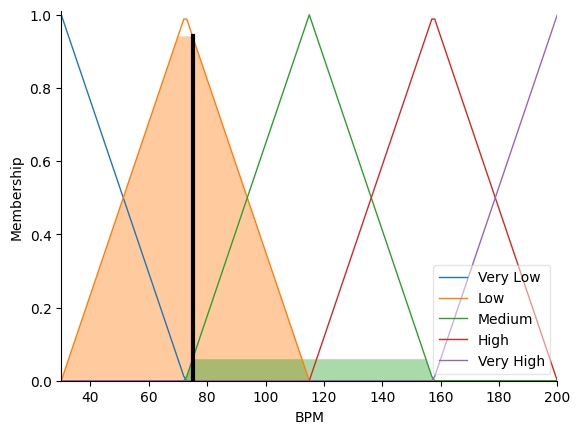

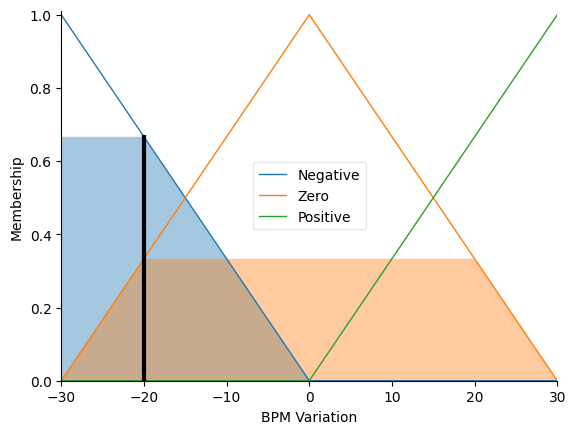

In [40]:
bpm = 75
bpm_variation = -20
calculate_intensity_fuzzy(bpm, bpm_variation, plot_consequent = True, plot_antecedent = True)

### Energy calculator

In [37]:
class FuzzyController:
    def __init__(self):
        self.bpm_antecedent = ctrl.Antecedent(np.arange(30, 201, 1), 'BPM')
        self.bpm_variation_antecedent = ctrl.Antecedent(np.arange(-30, 31, 1), 'BPM Variation')
        self.intensity_consequent = ctrl.Consequent(np.arange(0, 101, 1), 'Intensity')

        self.bpm_antecedent.automf(5, names=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        self.bpm_variation_antecedent.automf(3, names=['Negative', 'Zero', 'Positive'])
        self.intensity_consequent.automf(3, names=['Low', 'Medium', 'High'])

        rule1 = ctrl.Rule(antecedent= (bpm_antecedent['Very Low'] |
                        (bpm_antecedent['Low'] & bpm_variation_antecedent['Negative']) |
                        (bpm_antecedent['Low'] & bpm_variation_antecedent['Zero']) |
                        (bpm_antecedent['Medium'] & bpm_variation_antecedent['Negative'])),
                        consequent=intensity_consequent['High'])
        rule2 = ctrl.Rule(antecedent=((bpm_antecedent['Low'] & bpm_variation_antecedent['Positive']) |
                                (bpm_antecedent['Medium'] & bpm_variation_antecedent['Zero']) |
                                (bpm_antecedent['High'] & bpm_variation_antecedent['Negative'])),
                                consequent=intensity_consequent['Medium'])
        rule3 = ctrl.Rule(antecedent=((bpm_antecedent['Medium'] & bpm_variation_antecedent['Positive']) |
                        (bpm_antecedent['High'] & bpm_variation_antecedent['Zero']) |
                        (bpm_antecedent['High'] & bpm_variation_antecedent['Positive'])),
                        consequent=intensity_consequent['Low'])

        intensity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
        self.intensity_sim = ctrl.ControlSystemSimulation(intensity_ctrl)

    def view_bpm_antecedent(self):
        self.bpm_antecedent.view()
    
    def view_bpm_variation_antecedent(self):
        self.bpm_variation_antecedent.view()

    def view_intensity_consequent(self):
        self.intensity_consequent.view()


In [ ]:
class EnergyCalculator:
    def __init__(self, df_gym, df_heart_rates, fuzzy_controller=None):
        self.df_gym = df_gym
        self.df_heart_rates = df_heart_rates
        if fuzzy_controller is None:
            self.fuzzy_controller = FuzzyController()
        else:
            self.fuzzy_controller = fuzzy_controller

    def calculate_intensity_fuzzy(self, bpm, bpm_variation, plot_consequent=False, plot_antecedent=False):
        #TODO cambiar esta funcion
        intensity_sim.input['BPM'] = bpm
        intensity_sim.input['BPM Variation'] = bpm_variation
        intensity_sim.compute()
        if plot_consequent:
            intensity_consequent.view(sim=intensity_sim)
        if plot_antecedent:
            bpm_antecedent.view(sim=intensity_sim)
            bpm_variation_antecedent.view(sim=intensity_sim)
        return intensity_sim.output['Intensity']
    
    def view_bpm_antecedent(self):
        self.fuzzy_controller.view_bpm_antecedent()
    
    def view_bpm_variation_antecedent(self):
        self.fuzzy_controller.view_bpm_variation_antecedent()
    
    def view_intensity_consequent(self):
        self.fuzzy_controller.view_intensity_consequent()

In [40]:
energyCalculator = EnergyCalculator(df_gym, df_heart_rates)

TODO a partir de aqui no lo he modificado todavia

In [42]:
def calculate_session_moment_intensity(generated_bpms, minute, print_values=False, plot_consequent=False, plot_antecedent=False):
    bpm_registered = generated_bpms[minute]
    if minute == 0:
        bpm_variation = 0
    else:
        last_bpm = genarated_heart_rates_session[minute - 1]
        bpm_variation = bpm_registered - last_bpm

    if print_values:
        print(f"Minute analized: {minute}")
        print(f"BPM registered: {bpm_registered}")
        print(f"Last BPM: {last_bpm}")
        print(f"BPM variation: {bpm_variation}")
    
    intensity = calculate_intensity_fuzzy(bpm_registered, bpm_variation, plot_consequent, plot_antecedent)
    if print_values:
        print(f"Intensity: {intensity}")
    return intensity

In [43]:
session_analized = df_gym.iloc[2]
session_analized['Workout_Type']

'Cardio'

Min: 54, Max: 167, Avg: 122, Std: 16.46049936331129, N: 66
Real average: 122.77
Real std: 18.65
Real min: 81.49
Real max: 156.98




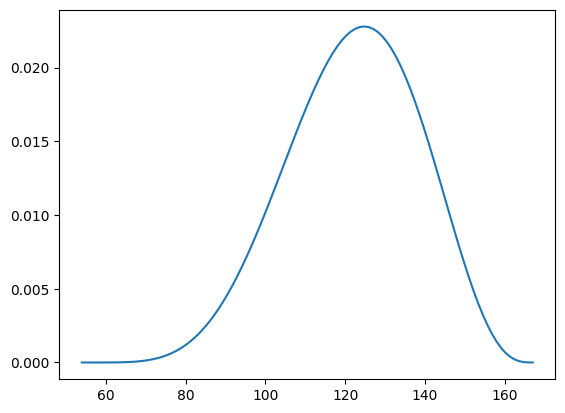

In [44]:
min_val, max_val, avg, N = session_analized['Resting_BPM'], session_analized['Max_BPM'], session_analized['Avg_BPM'], math.trunc(session_analized['Session_Duration (hours)'] * 60)
std = mean_std_ratio_avg_max * (max_val - avg)

try:
    genarated_heart_rates_session = genarate_heart_rates_beta(min_val, max_val, avg, std, N, True)

    print(f"Min: {min_val}, Max: {max_val}, Avg: {avg}, Std: {std}, N: {N}")
    
    print(f"Real average: {np.mean(genarated_heart_rates_session):.2f}")
    print(f"Real std: {np.std(genarated_heart_rates_session, ddof=1):.2f}")
    print(f"Real min: {np.min(genarated_heart_rates_session):.2f}")
    print(f"Real max: {np.max(genarated_heart_rates_session):.2f}")

    print('\n')
except Exception as e:
    print(f"Error for index {index}: {e}")

In [45]:
genarated_heart_rates_session

array([137.9994604 , 105.26451654, 126.09230001, 123.80809677,
       124.38219133, 147.78767639, 136.96664357, 124.15176477,
       148.43552304, 103.14379277, 152.9002033 , 102.86119188,
       125.11008856, 108.28159123, 117.37715439, 132.49156869,
       122.03737481, 136.88216193,  84.39084636, 108.74255686,
       125.57248231, 103.1364639 , 117.94039918,  92.64502349,
       135.84297663, 126.12972141,  94.92487822, 135.16433751,
       135.7561488 , 126.59831139, 106.63463964,  85.67930854,
       141.10419993, 142.28319166, 127.73018067,  93.48791643,
       132.23184591, 108.49889176, 124.28290345, 116.3842251 ,
       110.64544343, 137.46288091, 116.45304578, 140.67199686,
       145.17741112, 131.79070385, 150.67798847,  92.33339807,
       115.98530243, 140.84672925, 118.11075605, 148.48481668,
       147.18259133,  81.49398312, 117.47356252, 141.79893834,
       108.55941947, 143.77455183, 121.71569879,  99.61855232,
       114.40458276, 106.12385242, 156.98059506, 111.41

In [46]:
# Valor objetivo
target_value = 154.69513211

# Encontrar la posición del valor más cercano
closest_index = np.abs(genarated_heart_rates_session - target_value).argmin()
closest_value = genarated_heart_rates_session[closest_index]

print(f"Posición más cercana: {closest_index}")
print(f"Valor más cercano: {closest_value}")

Posición más cercana: 10
Valor más cercano: 152.90020330068634


Minute analized: 15
BPM registered: 132.49156869241892
Last BPM: 117.37715439440612
BPM variation: 15.114414298012804
Intensity: 43.951801538057225


c:\Users\Dani\.conda\envs\Master-IA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


np.float64(43.951801538057225)

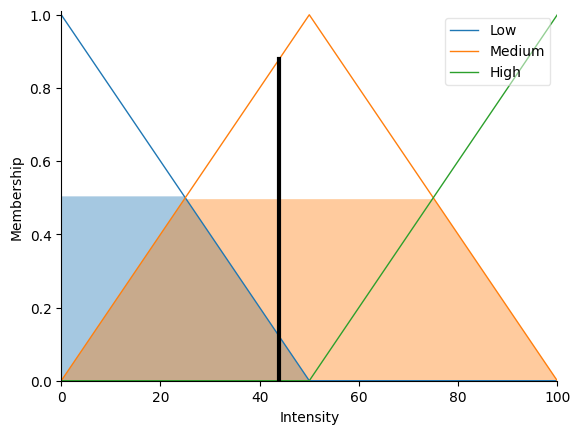

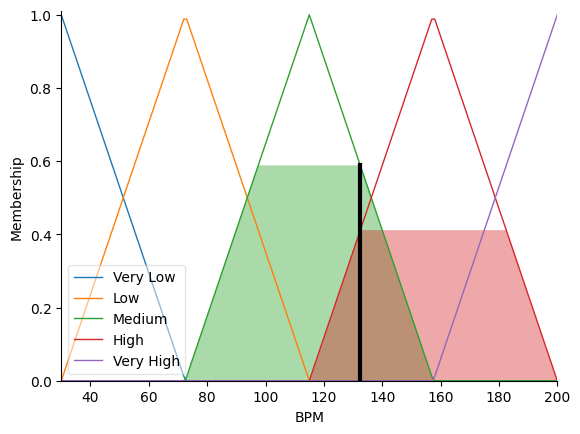

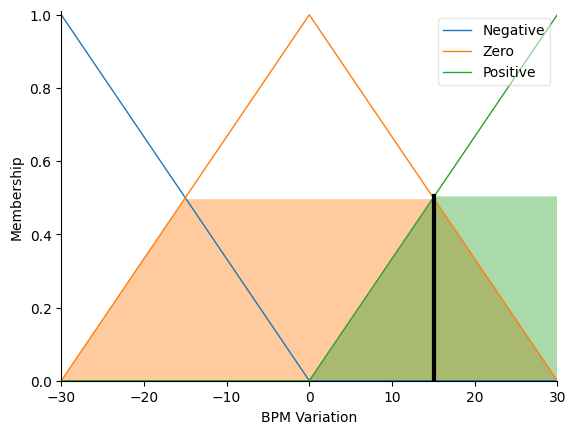

In [47]:
calculate_session_moment_intensity(genarated_heart_rates_session, minute = 15, print_values=True, plot_consequent = True, plot_antecedent = True)

Minute analized: 20
BPM registered: 125.57248230998022
Last BPM: 108.74255686193112
BPM variation: 16.829925448049096
Intensity: 42.40864351679399


np.float64(42.40864351679399)

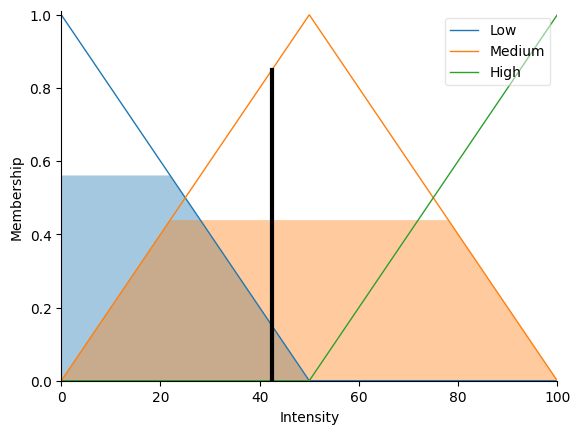

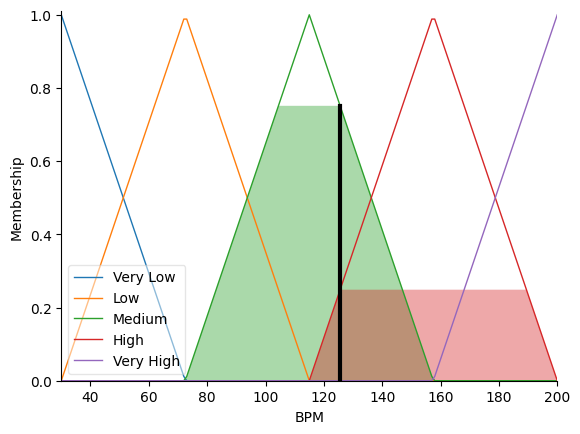

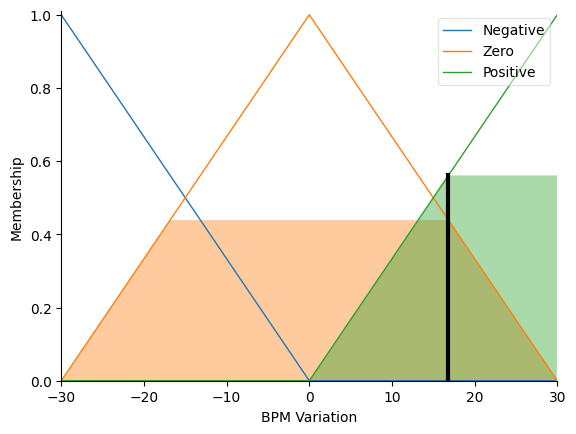

In [48]:
calculate_session_moment_intensity(genarated_heart_rates_session, minute = 20, print_values=True, plot_consequent = True, plot_antecedent = True)

Minute analized: 53
BPM registered: 81.49398311781364
Last BPM: 147.1825913300649
BPM variation: -65.68860821225125
Intensity: 82.71729537997807


np.float64(82.71729537997807)

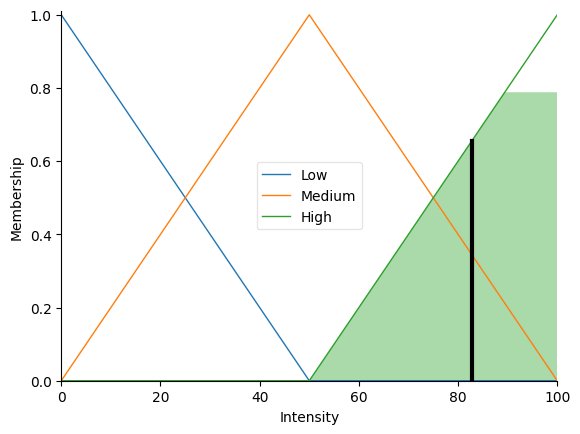

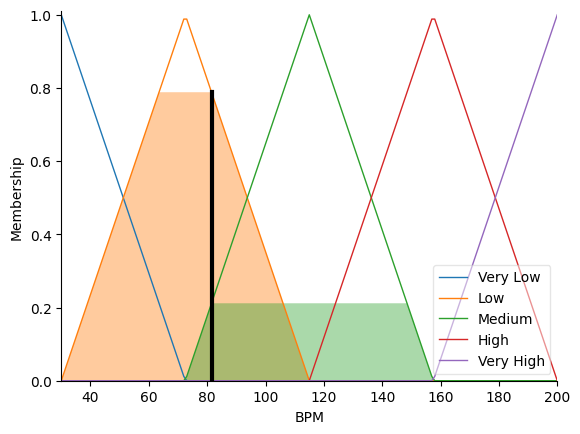

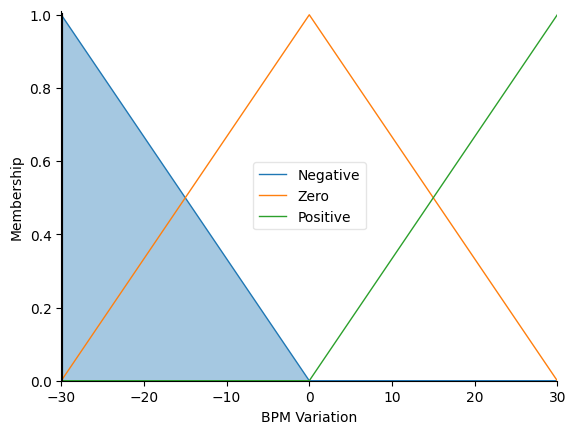

In [49]:
calculate_session_moment_intensity(genarated_heart_rates_session, minute = 53, print_values=True, plot_consequent = True, plot_antecedent = True)